In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib import colors
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import RELACS as rel
import pymc3 as pm
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: Run

In [61]:
%%bash 

multiBamSummary BED-file -b /home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/filtered_bam/NPC48hs_*.filtered.bam \
-o ../INTERMEDIATE_FILES/NPC48h_ATAC_DMSO-EPZ.mat.gz \
--BED /home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/MACS2_mine/NPC48hs_MACS2_BAMPE_consensusSet.bed \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
-p 20 \
--outRawCounts ../INTERMEDIATE_FILES/NPC48h_ATAC_DMSO-EPZ.counts \
-e \
--minMappingQuality 5 

Number of bins found: 32232


In [108]:
### IMPORT COUNTS ###

peak = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_ATAC_DMSO-EPZ.counts",sep="\t")
peak.columns = ["chr","start","end","DMSO1","DMSO2","EPZ1","EPZ2"]
peak = peak.loc[peak.chr != "MT"]

peak.sample(1000)[["chr","start","end"]].to_csv("../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed",sep="\t",header=None,index=None)

peak["ID"] = ['_'.join([str(peak.chr.loc[i]), str(peak.start.loc[i]),str(peak.end.loc[i])]) for i in peak.index]
peak = peak[list(peak)[3:]]
peak.drop_duplicates("ID",inplace=True)
print(peak.shape)
peak.head()

(32232, 5)


,DMSO1,DMSO2,EPZ1,EPZ2,ID
0,6.0,14.0,5.0,23.0,18_89620972_89621286
1,285.0,131.0,142.0,118.0,7_43562057_43562893
2,328.0,186.0,206.0,190.0,7_43579417_43580316
3,15.0,9.0,8.0,22.0,17_90018305_90018554
4,36.0,41.0,23.0,32.0,17_90086889_90087150


In [104]:
peak.sample(1000)

,DMSO1,DMSO2,EPZ1,EPZ2,ID
26869,274.0,161.0,176.0,158.0,1_90743663_90744443
22687,170.0,133.0,110.0,88.0,10_112928534_112929392
26400,68.0,17.0,26.0,14.0,1_132200979_132201168
2992,287.0,141.0,187.0,184.0,15_79402572_79403730
22714,238.0,142.0,94.0,156.0,6_53286687_53287868
...,...,...,...,...,...
15750,51.0,20.0,26.0,19.0,X_130502861_130503373
21360,43.0,26.0,25.0,35.0,13_112153218_112153476
7844,17.0,21.0,4.0,15.0,2_57213883_57214136
20701,14.0,8.0,26.0,9.0,2_49495155_49495357


/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  warnings.warn(x, RRuntimeWarning)


                     DMSO1 DMSO2 EPZ1 EPZ2
18_89620972_89621286     6    14    5   23
7_43562057_43562893    285   131  142  118
7_43579417_43580316    328   186  206  190
17_90018305_90018554    15     9    8   22
17_90086889_90087150    36    41   23   32
13_58654396_58654765    32    25   40    0
    DMSO1     DMSO2      EPZ1      EPZ2 
1.5692012 0.9435316 0.8584889 0.7929614 


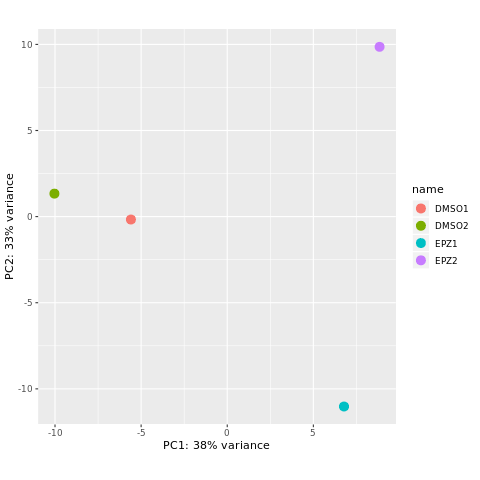

In [63]:
%%R -i peak

library("DESeq2")
library("ggplot2")

rownames(peak) = peak$ID

peak = peak[,c(1,2,3,4)]

print(head(peak))

# CREATE DESIGN TABLE
design_table=data.frame(row.names = colnames(peak),
                        condition = c(rep("DMSO",2),rep("EPZ",2)))


all(rownames(design_table) == colnames(count))

# CREATE DESEQ2 OBJECT
dds = DESeqDataSetFromMatrix(countData = peak,
                              colData = design_table,
                              design = ~ condition)

dds <- estimateSizeFactors(dds)
print(dds@colData$sizeFactor)

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]


rld = rlog(dds, blind=TRUE)

A=plotPCA(rld, ntop=dim(assay(rld))[1], returnData=T, intgroup=c("condition"))
percentVar <- round(100 * attr(A, "percentVar"))
pca_plt=ggplot(A, aes(x=PC1, y=PC2, col=name))+
  geom_point(size=4)+
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed()


matrix_rlog=as.data.frame(t(assay(rld)))
write.table(matrix_rlog,"../INTERMEDIATE_FILES/matrix_rlog-all_atac.tsv",sep="\t",quote=F)

pca_plt

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

rlog = pd.read_csv("../INTERMEDIATE_FILES/matrix_rlog-all_atac.tsv",sep="\t")
rlog

X = rlog
y=pd.Series(["class_0","class_0","class_1","class_1"])

le = LabelEncoder()
y_ = le.fit_transform(y)

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y_)
X_lda
rank = pd.Series(lda.scalings_.reshape(32227,), index = X.columns)
np.fabs(rank).sort_values(ascending=False)
# plt.figure(dpi=400)
# plt.xlabel('LD1\n({}%)'.format(round(lda.explained_variance_ratio_[0]*100,2)))
# plt.ylabel('LD2\n({}%)'.format(round(lda.explained_variance_ratio_[1]*100,2)))
# cols={0:'r',1:'b'}
# plt.scatter(
#     X_lda[:,0],
#     X_lda[:,1],
#     c=[cols[i]for i in y],
#     cmap='rainbow',
#     alpha=0.7,
#     edgecolors='b'
# )




/home/ferrari/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


5_104046455_104047056     1.020389e-01
6_113696672_113697280     5.035632e-02
13_74522163_74522955      3.892128e-02
2_164961231_164961460     3.884272e-02
15_92808510_92808713      3.576694e-02
                              ...     
4_117373414_117374401     4.542711e-07
10_118250904_118251233    3.204411e-07
4_122998621_122999627     1.930714e-07
5_37576076_37576295       1.077569e-07
3_70150344_70150541       7.756812e-08
Length: 32227, dtype: float64

             PC1        PC2        PC3           PC4
DMSO1   5.591424   0.167874  10.904768  7.366765e-14
DMSO2  10.034430  -1.334674  -8.128782  7.366765e-14
EPZ1   -6.780055  11.025236  -1.917612  7.366765e-14
EPZ2   -8.845799  -9.858436  -0.858373  7.366765e-14


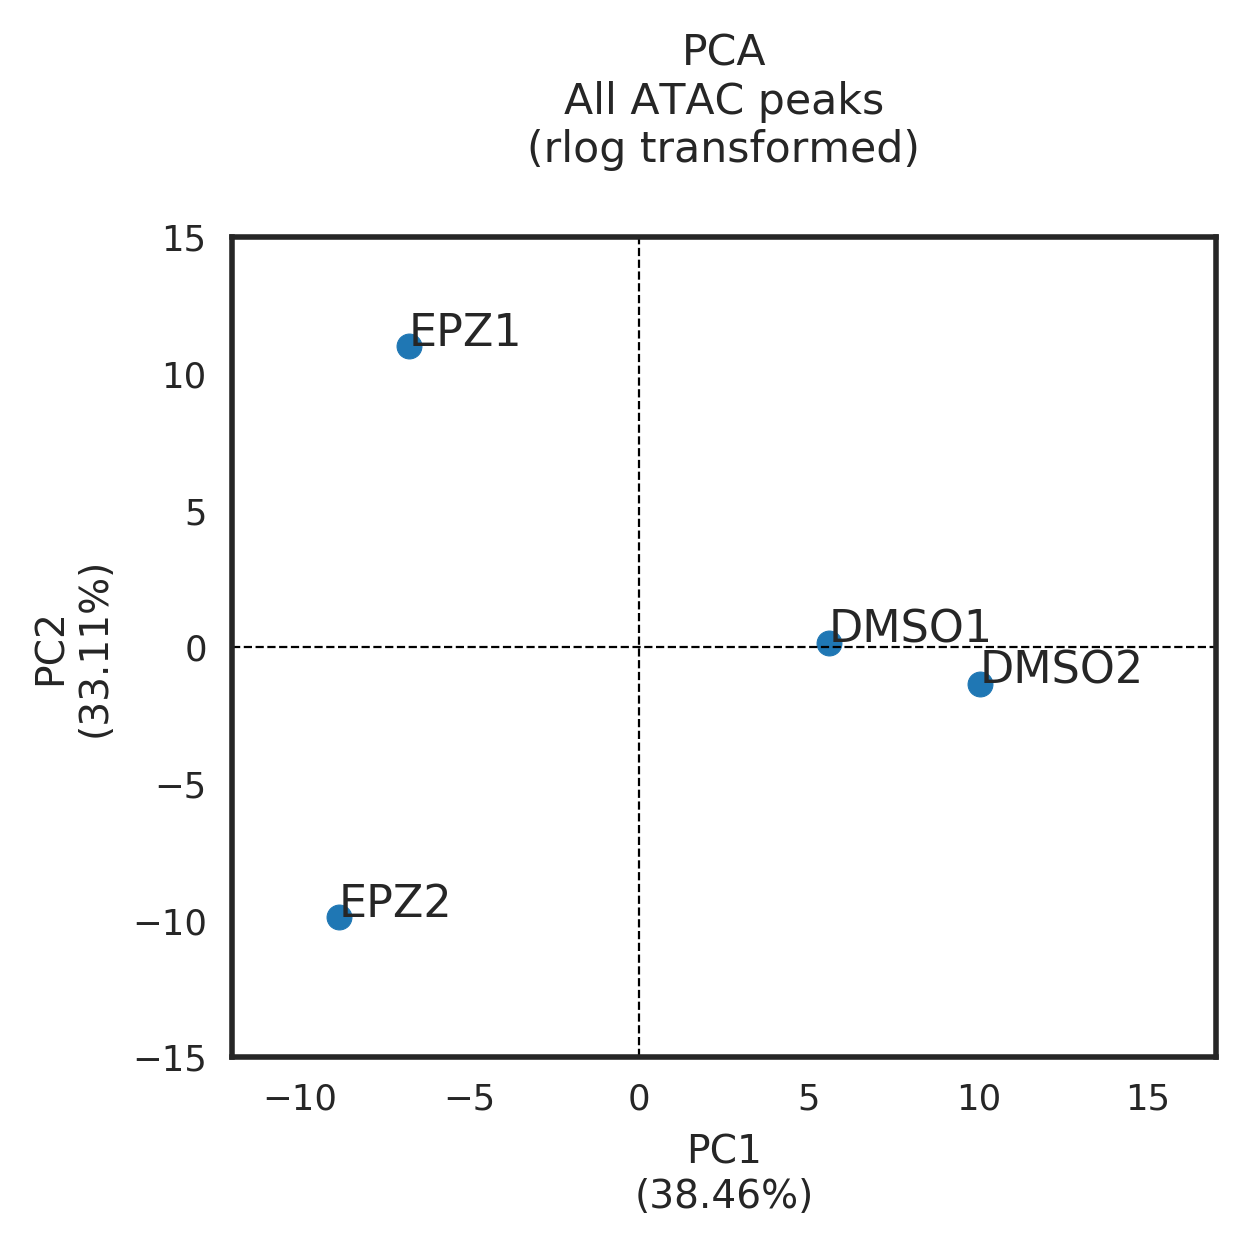

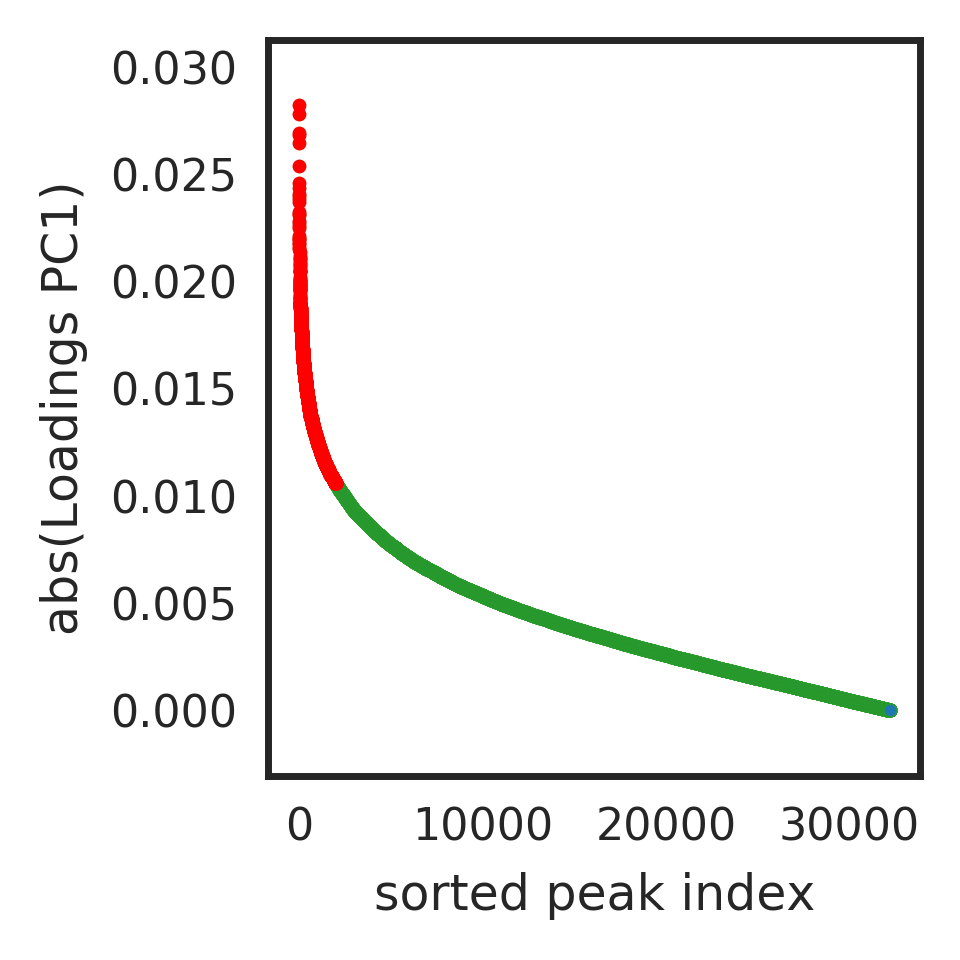

In [64]:
### HERE WE PERFORM PCA USING SKLEARN ### 

rlog = pd.read_csv("../INTERMEDIATE_FILES/matrix_rlog-all_atac.tsv",sep="\t")
rlog.head()

pca = PCA()
pca_data = pca.fit_transform(rlog)

per_variance = [round(i,2)*100 for i in pca.explained_variance_ratio_]
labels = ["PC{}".format(i) for i in range(len(per_variance)+1)[1:]]

# HERE WE PLOT THE ACTUAL PCA PLOT ###

# first, let's put the data into a nice dataframe format
pca_df = pd.DataFrame(pca_data, index = ["DMSO1","DMSO2","EPZ1","EPZ2"], columns=labels)
print(pca_df.head())

plt.figure(dpi=320, figsize=(4,4))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("PCA\nAll ATAC peaks\n(rlog transformed)\n")
plt.xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
plt.ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.ylim((-15,15))
plt.xlim((-12,17))
plt.axhline(0,linestyle="--",linewidth=0.5, color="k")
plt.axvline(0,linestyle="--",linewidth=0.5, color="k")
plt.tight_layout()

plt.savefig("../FIGURES/PCA_ATACPeaks.png")





genes = rlog.columns
    
loading_scores_PC1 = pd.Series(pca.components_[0], index = genes)
sorted_loadings_PC1 = loading_scores_PC1.abs().sort_values(ascending=False)

All_genes_PC1 = sorted_loadings_PC1.index.values
top_500_genes_PC1 = sorted_loadings_PC1[:2000].index.values
# print("TOP 10 PC1 GENES:\n",loading_scores_PC1[top_500_genes_PC1],'\n')

# loading_scores_PC2 = pd.Series(pca.components_[1], index = genes)
# sorted_loadings_PC2 = loading_scores_PC2.abs().sort_values(ascending=False)

# top_10_genes_PC2 = sorted_loadings_PC2[:500].index.values
# print("TOP 10 PC2 GENES:\n",loading_scores_PC2[top_10_genes_PC2])

plt.figure(dpi=400,figsize=(2.5,2.5))
plt.scatter(range(len(loading_scores_PC1[All_genes_PC1].values)), np.fabs(loading_scores_PC1[All_genes_PC1]), s=5,edgecolor='C2',facecolor=None,alpha=0.4)
plt.scatter(range(len(loading_scores_PC1[top_500_genes_PC1].values)), np.fabs(loading_scores_PC1[top_500_genes_PC1]), s=5,color='r',zorder=1)
plt.ylabel("abs(Loadings PC1)")
plt.xlabel("sorted peak index")
plt.tight_layout()
plt.savefig("../FIGURES/sorted_loadings_PC1_ATACPeaks.png")

In [65]:
loading_scores_PC1 = pd.Series(pca.components_[0], index = genes)
sorted_loadings_PC1 = loading_scores_PC1.abs().sort_values(ascending=False)

top_1000_genes_PC1 = sorted_loadings_PC1[:2000].index.values
t1000_PC1 = loading_scores_PC1[top_1000_genes_PC1]

with open("../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv",'w') as out:
    for i in range(2000):
        idx =t1000_PC1.index[i]
        #print(idx, t500_PC2.loc[idx])
        bed = idx.split("_")
        bed = bed + ["topPeak_{}".format(i+1),str(t1000_PC1.loc[idx])+"\n"]
        print(bed)
        out.write("\t".join(bed))



['12', '12723075', '12724107', 'topPeak_1', '0.02822411641869639\n']
['15', '74958663', '74959169', 'topPeak_2', '-0.02782473059942398\n']
['11', '20830556', '20831732', 'topPeak_3', '-0.026934407907050494\n']
['4', '65699964', '65700588', 'topPeak_4', '-0.026822488757241823\n']
['3', '38912896', '38914192', 'topPeak_5', '0.02644405560724489\n']
['1', '74103594', '74104245', 'topPeak_6', '0.02539750426983653\n']
['14', '79905401', '79906076', 'topPeak_7', '0.02458736097216066\n']
['7', '100498788', '100499362', 'topPeak_8', '-0.02437419780295775\n']
['12', '120028668', '120029014', 'topPeak_9', '-0.024086987733856383\n']
['16', '16860705', '16861067', 'topPeak_10', '-0.023983041396454685\n']
['6', '87545238', '87546089', 'topPeak_11', '0.023828806914983472\n']
['8', '129253030', '129253717', 'topPeak_12', '-0.023714001337096807\n']
['2', '49633208', '49633897', 'topPeak_13', '0.023227525379579467\n']
['18', '54452415', '54453481', 'topPeak_14', '0.02313783186764303\n']
['8', '123427327

['1', '169051575', '169051985', 'topPeak_1777', '0.010924322657137291\n']
['8', '89271366', '89272566', 'topPeak_1778', '0.010923198853542558\n']
['1', '150099647', '150100328', 'topPeak_1779', '-0.010922466363708465\n']
['6', '40019556', '40019985', 'topPeak_1780', '0.010922043428761413\n']
['10', '82858932', '82859770', 'topPeak_1781', '0.010921084700211397\n']
['1', '38657704', '38658136', 'topPeak_1782', '-0.010920767917061501\n']
['5', '117413729', '117414441', 'topPeak_1783', '-0.010920458895337534\n']
['2', '25557545', '25558125', 'topPeak_1784', '0.010919662143812854\n']
['9', '108190036', '108190605', 'topPeak_1785', '-0.0109192100107178\n']
['13', '40722492', '40723380', 'topPeak_1786', '-0.010918979378573638\n']
['18', '65559975', '65560325', 'topPeak_1787', '-0.010918181638408152\n']
['1', '83316979', '83317282', 'topPeak_1788', '0.010916089694770795\n']
['8', '105893361', '105893633', 'topPeak_1789', '0.010914518760950011\n']
['2', '90940169', '90941067', 'topPeak_1790', '

In [66]:
%%bash

awk -v OFS="\t" '{if($5>0){print $0}}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv
awk -v OFS="\t" '{if($5<0){print $0}}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv



In [40]:
!head ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv

12	12723075	12724107	topPeak_1	0.02822411641869639
3	38912896	38914192	topPeak_5	0.02644405560724489
1	74103594	74104245	topPeak_6	0.02539750426983653
14	79905401	79906076	topPeak_7	0.02458736097216066
6	87545238	87546089	topPeak_11	0.023828806914983472
2	49633208	49633897	topPeak_13	0.023227525379579467
18	54452415	54453481	topPeak_14	0.02313783186764303
6	94631143	94632035	topPeak_16	0.022840117416709667
7	93037769	93038690	topPeak_18	0.022583256176193195
7	130264575	130265344	topPeak_19	0.022510598266836417


In [67]:
%%bash

### ATAC-PEAKS ANNOTATION ### 

source activate Homer

annotatePeaks.pl ../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv mm10 \
-gtf /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf \
> ../INTERMEDIATE_FILES/ATAC_topVar_PC1.annotated


	Peak file = ../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv
	Genome = mm10
	Organism = mouse
	Custom annotation GTF file: /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf (using transcript_id)
	Peak/BED file conversion summary:
		BED/Header formatted lines: 2000
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 2000
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Processing custom annotation file...
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Features that will be considered:
		exon

	807591 lines contained useful feature information
	Prioritizing Annotations: ..

# CREATE REFERENCE DATASET

### BY COMBINING ALL TABLES CREATED SO FAR

In [68]:
rlog.T.head()
final_table = rlog.T.copy()
final_table["mean_DMSO"] = final_table[["DMSO1","DMSO2"]].mean(axis=1)
final_table["mean_EPZ"] = final_table[["EPZ1","EPZ2"]].mean(axis=1)
final_table["LogRatio"] = final_table["mean_EPZ"] - final_table["mean_DMSO"]
final_table = final_table.reindex(index = t1000_PC1.index)
final_table_1 = final_table.merge(t1000_PC1.to_frame(), how='left', right_index=True, left_index=True)
final_table_1.columns =  list(final_table_1)[:-1]+["PC1_loadings"] 
final_table_1.head()

de = pd.read_csv("../../figure_3/INTERMEDIATE_FILES/DE_genes_shrinked_apeglm_NPC48h_EPZvsDMSO.tsv",sep="\t")

In [69]:
ddd = pd.read_csv("../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv",sep="\t", header=None)
ddd.index = ['_'.join([str(ddd[0].loc[i]), str(ddd[1].loc[i]),str(ddd[2].loc[i])]) for i in ddd.index]
ddd
final_table_2 = final_table_1.merge(ddd, how='left',right_index=True,left_index=True)
final_table_2.index = final_table_2[3]
final_table_2.columns = list(final_table_2)[:7] + ["Loadings_PC1","chr","start","end","peakID","load"] 
final_table_2 = final_table_2[list(final_table_2)[:-1]]
final_table_2

,DMSO1,DMSO2,EPZ1,EPZ2,mean_DMSO,mean_EPZ,LogRatio,Loadings_PC1,chr,start,end,peakID
3,,,,,,,,,,,,
topPeak_1,8.289937,8.295500,7.867517,7.802660,8.292718,7.835089,-0.457630,0.028224,12,12723075,12724107,topPeak_1
topPeak_2,5.057459,5.098516,5.572876,5.514775,5.077988,5.543825,0.465838,-0.027825,15,74958663,74959169,topPeak_2
topPeak_3,6.906323,6.673350,7.099741,7.273806,6.789836,7.186773,0.396937,-0.026934,11,20830556,20831732,topPeak_3
topPeak_4,5.836656,5.732227,6.269172,6.163453,5.784441,6.216312,0.431871,-0.026822,4,65699964,65700588,topPeak_4
topPeak_5,8.163584,8.357048,7.875378,7.838135,8.260316,7.856757,-0.403559,0.026444,3,38912896,38914192,topPeak_5
...,...,...,...,...,...,...,...,...,...,...,...,...
topPeak_1996,7.759730,7.734130,7.673473,7.489763,7.746930,7.581618,-0.165312,0.010602,5,85239477,85240520,topPeak_1996
topPeak_1997,5.133450,5.239946,4.971387,5.071544,5.186698,5.021465,-0.165233,0.010599,3,144719414,144719692,topPeak_1997
topPeak_1998,6.731489,6.934424,6.588100,6.764695,6.832956,6.676397,-0.156559,0.010598,4,136776379,136776958,topPeak_1998


In [70]:
anno = pd.read_csv("../INTERMEDIATE_FILES/ATAC_topVar_PC1.annotated",sep="\t")
anno.index = anno[list(anno)[0]]
anno["Annotation_overlap"] = [i.split("(")[1].split(")")[0].split(",")[0] if len(i.split("("))>=2 else i for i in anno.Annotation.values ]
anno["Annotation_type"] = [i.split("(")[0].strip() for i in anno.Annotation.values ]
anno.head()
final_table_3 = final_table_2.merge(anno, how='left', right_index=True, left_index=True)
final_table_3 = final_table_3[list(final_table_3)[:12]+["Nearest PromoterID", "Annotation_overlap", "Annotation_type"]]
final_table_3


,DMSO1,DMSO2,EPZ1,EPZ2,mean_DMSO,mean_EPZ,LogRatio,Loadings_PC1,chr,start,end,peakID,Nearest PromoterID,Annotation_overlap,Annotation_type
3,,,,,,,,,,,,,,,
topPeak_1,8.289937,8.295500,7.867517,7.802660,8.292718,7.835089,-0.457630,0.028224,12,12723075,12724107,topPeak_1,ENSMUST00000222770.1,ENSMUST00000222770.1,exon
topPeak_2,5.057459,5.098516,5.572876,5.514775,5.077988,5.543825,0.465838,-0.027825,15,74958663,74959169,topPeak_2,ENSMUST00000188042.1,ENSMUST00000185863.6,TTS
topPeak_3,6.906323,6.673350,7.099741,7.273806,6.789836,7.186773,0.396937,-0.026934,11,20830556,20831732,topPeak_3,ENSMUST00000154300.7,ENSMUST00000154300.7,promoter-TSS
topPeak_4,5.836656,5.732227,6.269172,6.163453,5.784441,6.216312,0.431871,-0.026822,4,65699964,65700588,topPeak_4,ENSMUST00000155978.1,ENSMUST00000068214.10,intron
topPeak_5,8.163584,8.357048,7.875378,7.838135,8.260316,7.856757,-0.403559,0.026444,3,38912896,38914192,topPeak_5,ENSMUST00000129182.1,ENSMUST00000129182.1,intron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topPeak_1996,7.759730,7.734130,7.673473,7.489763,7.746930,7.581618,-0.165312,0.010602,5,85239477,85240520,topPeak_1996,ENSMUST00000196930.1,Intergenic,Intergenic
topPeak_1997,5.133450,5.239946,4.971387,5.071544,5.186698,5.021465,-0.165233,0.010599,3,144719414,144719692,topPeak_1997,ENSMUST00000199531.4,ENSMUST00000199854.4,intron
topPeak_1998,6.731489,6.934424,6.588100,6.764695,6.832956,6.676397,-0.156559,0.010598,4,136776379,136776958,topPeak_1998,ENSMUST00000105846.8,ENSMUST00000059287.13,intron


In [71]:
#%%bash

#extract_from_gtf.py -f TSS -o ../INTERMEDIATE_FILES/ -w transcript /home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf 

In [72]:
tr = pd.read_csv("../INTERMEDIATE_FILES/TSS.bed",sep="\t",header=None, index_col=7)
tr.columns = ["chr",'start','end','geneID','st','strand','name']
tr = tr[['geneID','name']]
tr.head()

#final_table_4 = final_table_3.merge(tr, how='left',right_index=True, left_on="Nearest PromoterID")
final_table_4 = final_table_3.merge(tr, how='left',right_index=True, left_on="Annotation_overlap")


/home/ferrari/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
final_table_5 = final_table_4.merge(de, how='left',right_index=True, left_on="geneID")
final_table_5.log2FoldChange.fillna(0,inplace=True)


In [74]:
%%bash 

multiBamSummary BED-file -b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_*_H3K79me2_merged.filtered.bam \
-o ../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks.mat.gz \
--BED  ../INTERMEDIATE_FILES/ATAC_topVar_PC1.tsv \
-bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
-p 20 \
--outRawCounts ../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks.counts \
-e \
--minMappingQuality 5

Number of bins found: 2000


In [75]:
cov = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_H3K79me2_onATACpeaks.counts", sep="\t")
cov["len"] = (cov["'end'"] - cov["'start'"])
cov = rel.preprocess_deeptools(cov)
cov["dens_H3K79me2"] = cov[list(cov)[:2]].mean(axis=1)/ (cov["len"].values/1000)
cov

,'iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam','iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam',len,dens_H3K79me2
5_15993308_15993884,18,31,576,42.534722
X_105070073_105070309,10,22,236,67.796610
4_3225560_3225752,4,16,192,52.083333
2_179821537_179821798,9,8,261,32.567050
6_88446129_88446622,6,16,493,22.312373
...,...,...,...,...
10_81378123_81379065,86,184,942,143.312102
X_141724943_141725862,5,10,919,8.161045
14_67072009_67072813,46,65,804,69.029851
13_97714838_97715195,5,5,357,14.005602


In [76]:
final_table_5["peak_id"] =['{}_{}_{}'.format(final_table_5["chr"].values[i],final_table_5["start"].values[i],final_table_5["end"].values[i]) for i in range(final_table_5.shape[0])]
final_table_5 = final_table_5.merge(cov[["dens_H3K79me2"]], how='right', left_on = "peak_id", right_index=True)
final_table_5  

,DMSO1,DMSO2,EPZ1,EPZ2,mean_DMSO,mean_EPZ,LogRatio,Loadings_PC1,chr,start,...,geneID,name,baseMean,log2FoldChange,lfcSE,pvalue,padj,symbol,peak_id,dens_H3K79me2
3,,,,,,,,,,,,,,,,,,,,,
topPeak_1,8.289937,8.295500,7.867517,7.802660,8.292718,7.835089,-0.457630,0.028224,12,12723075,...,ENSMUSG00000113009.1,RP24-399D3.2,1.931928,-0.000619,0.055850,0.546507,NaN,RP24-399D3.2,12_12723075_12724107,52.810078
topPeak_2,5.057459,5.098516,5.572876,5.514775,5.077988,5.543825,0.465838,-0.027825,15,74958663,...,ENSMUSG00000022587.14,Ly6e,1939.246988,0.064048,0.086006,0.059412,0.460735,Ly6e,15_74958663_74959169,23.715415
topPeak_3,6.906323,6.673350,7.099741,7.273806,6.789836,7.186773,0.396937,-0.026934,11,20830556,...,ENSMUSG00000042363.14,Lgalsl,3891.657873,-0.003791,0.046359,0.887415,0.979839,Lgalsl,11_20830556_20831732,45.068027
topPeak_4,5.836656,5.732227,6.269172,6.163453,5.784441,6.216312,0.431871,-0.026822,4,65699964,...,ENSMUSG00000028373.16,Astn2,2504.184729,0.055042,0.070036,0.098351,0.550696,Astn2,4_65699964_65700588,34.455128
topPeak_5,8.163584,8.357048,7.875378,7.838135,8.260316,7.856757,-0.403559,0.026444,3,38912896,...,ENSMUSG00000046743.6,Fat4,25204.397996,-0.112695,0.098742,0.020347,0.287391,Fat4,3_38912896_38914192,87.191358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topPeak_1996,7.759730,7.734130,7.673473,7.489763,7.746930,7.581618,-0.165312,0.010602,5,85239477,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,5_85239477_85240520,31.160115
topPeak_1997,5.133450,5.239946,4.971387,5.071544,5.186698,5.021465,-0.165233,0.010599,3,144719414,...,ENSMUSG00000037062.13,Sh3glb1,15791.492005,-0.024131,0.046895,0.403480,0.838617,Sh3glb1,3_144719414_144719692,151.079137
topPeak_1998,6.731489,6.934424,6.588100,6.764695,6.832956,6.676397,-0.156559,0.010598,4,136776379,...,ENSMUSG00000028664.14,Ephb2,22469.488947,-0.029267,0.049066,0.318255,0.791286,Ephb2,4_136776379_136776958,67.357513


In [77]:
final_table_5 = final_table_5.dropna(subset=["Annotation_type"])
final_table_5.to_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv",sep="\t")
final_table_5

,DMSO1,DMSO2,EPZ1,EPZ2,mean_DMSO,mean_EPZ,LogRatio,Loadings_PC1,chr,start,...,geneID,name,baseMean,log2FoldChange,lfcSE,pvalue,padj,symbol,peak_id,dens_H3K79me2
3,,,,,,,,,,,,,,,,,,,,,
topPeak_1,8.289937,8.295500,7.867517,7.802660,8.292718,7.835089,-0.457630,0.028224,12,12723075,...,ENSMUSG00000113009.1,RP24-399D3.2,1.931928,-0.000619,0.055850,0.546507,NaN,RP24-399D3.2,12_12723075_12724107,52.810078
topPeak_2,5.057459,5.098516,5.572876,5.514775,5.077988,5.543825,0.465838,-0.027825,15,74958663,...,ENSMUSG00000022587.14,Ly6e,1939.246988,0.064048,0.086006,0.059412,0.460735,Ly6e,15_74958663_74959169,23.715415
topPeak_3,6.906323,6.673350,7.099741,7.273806,6.789836,7.186773,0.396937,-0.026934,11,20830556,...,ENSMUSG00000042363.14,Lgalsl,3891.657873,-0.003791,0.046359,0.887415,0.979839,Lgalsl,11_20830556_20831732,45.068027
topPeak_4,5.836656,5.732227,6.269172,6.163453,5.784441,6.216312,0.431871,-0.026822,4,65699964,...,ENSMUSG00000028373.16,Astn2,2504.184729,0.055042,0.070036,0.098351,0.550696,Astn2,4_65699964_65700588,34.455128
topPeak_5,8.163584,8.357048,7.875378,7.838135,8.260316,7.856757,-0.403559,0.026444,3,38912896,...,ENSMUSG00000046743.6,Fat4,25204.397996,-0.112695,0.098742,0.020347,0.287391,Fat4,3_38912896_38914192,87.191358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topPeak_1996,7.759730,7.734130,7.673473,7.489763,7.746930,7.581618,-0.165312,0.010602,5,85239477,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,5_85239477_85240520,31.160115
topPeak_1997,5.133450,5.239946,4.971387,5.071544,5.186698,5.021465,-0.165233,0.010599,3,144719414,...,ENSMUSG00000037062.13,Sh3glb1,15791.492005,-0.024131,0.046895,0.403480,0.838617,Sh3glb1,3_144719414_144719692,151.079137
topPeak_1998,6.731489,6.934424,6.588100,6.764695,6.832956,6.676397,-0.156559,0.010598,4,136776379,...,ENSMUSG00000028664.14,Ephb2,22469.488947,-0.029267,0.049066,0.318255,0.791286,Ephb2,4_136776379_136776958,67.357513


# PLOT RESULTS

In [19]:
import sys
sys.path.append("/home/ferrari/anaconda3/lib/python3.7/site-packages/")

from adjustText import adjust_text

39


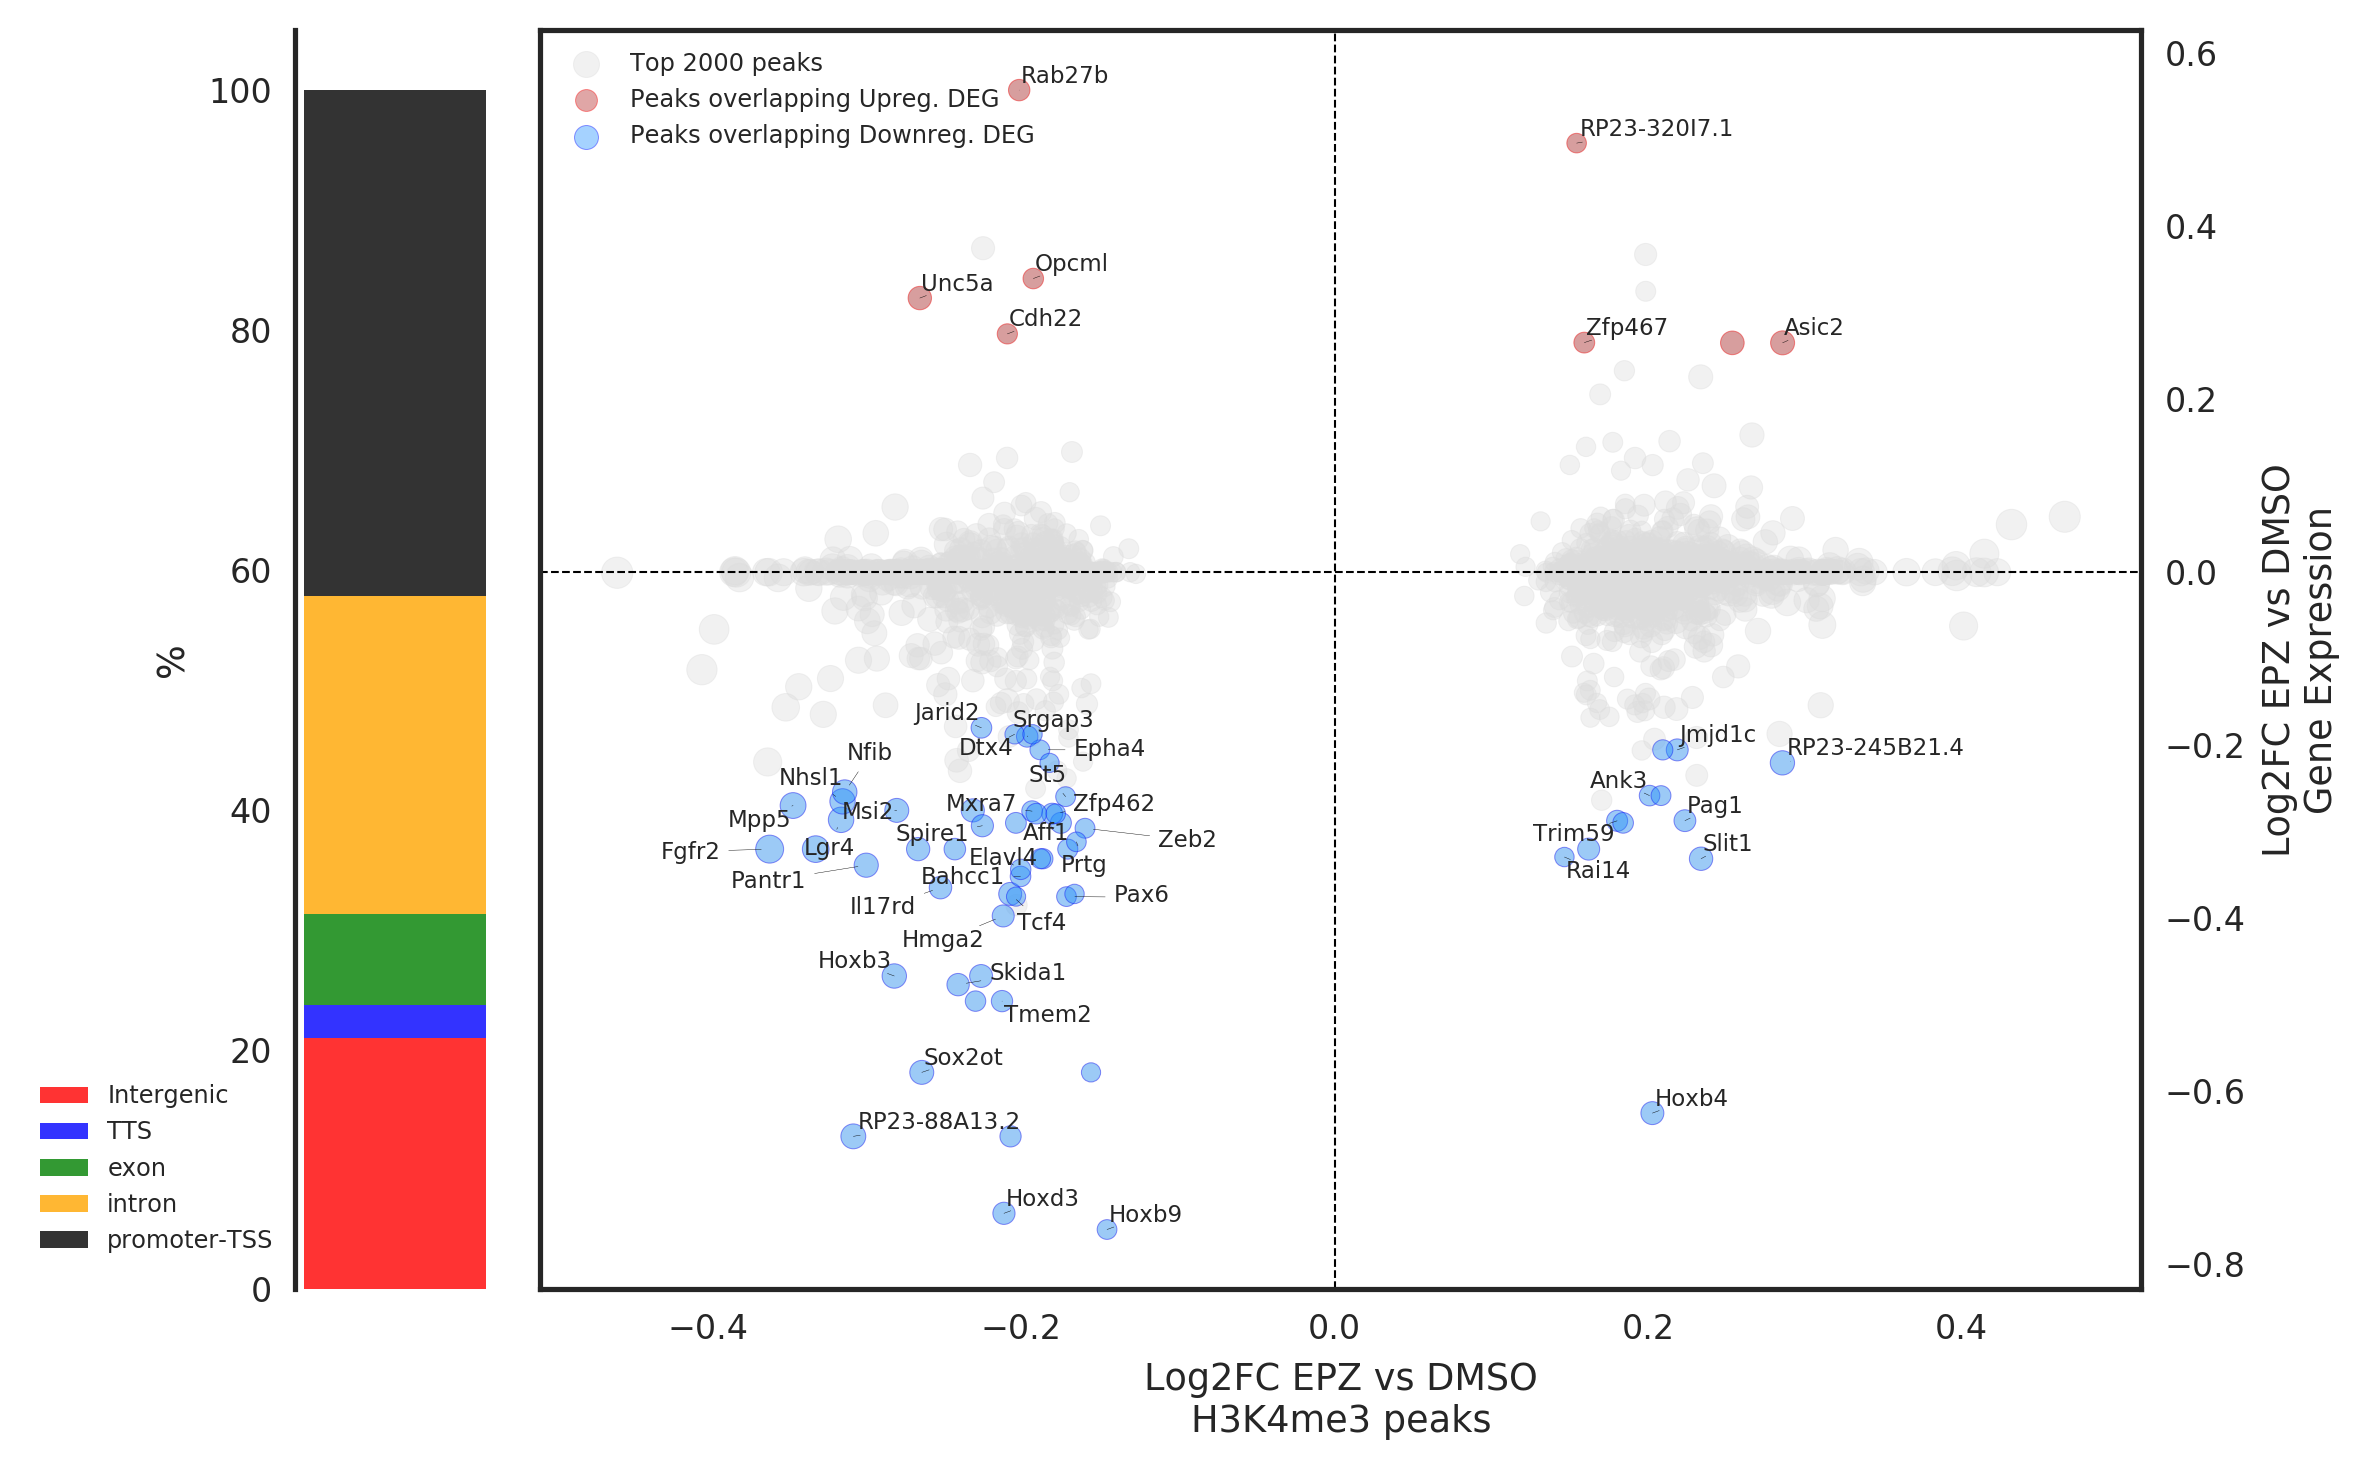

In [80]:
fig,ax = plt.subplots(1,2, dpi=300,figsize=(8,5), gridspec_kw = {'width_ratios':[1, 8]})

padj_thr = 0.05
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].scatter(final_table_5["LogRatio"].values,final_table_5["log2FoldChange"].values,s=np.fabs(final_table_5.Loadings_PC1*2000), color='gainsboro', label="Top 2000 peaks", alpha=0.4)
#plt.scatter(final_table_5["LogRatio"].values[:100],final_table_5["log2FoldChange"].values[:100],s=1)
#plt.scatter(final_table_5["LogRatio"].values[100:],final_table_5["log2FoldChange"].values[100:],s=1)
ax[1].scatter(final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values,final_table_5["log2FoldChange"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values,s=np.fabs(final_table_5.Loadings_PC1.loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)]*2000), facecolor='firebrick',edgecolor='r', alpha=0.4, label="Peaks overlapping Upreg. DEG ")
ax[1].scatter(final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values,final_table_5["log2FoldChange"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values,s=np.fabs(final_table_5.Loadings_PC1.loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)]*2000), facecolor='dodgerblue',edgecolor='b', alpha=0.4, label="Peaks overlapping Downreg. DEG")
#print(final_table_5[["name",'chr','start','end']].loc[(final_table_5.padj<0.1)&(final_table_5.log2FoldChange<0)])
print(len(set(final_table_5["name"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)])))
ax[1].axvline(0,linestyle="--",linewidth=0.5, color='k')
ax[1].axhline(0,linestyle="--",linewidth=0.5,color='k')
ax[1].set_ylabel("Log2FC EPZ vs DMSO\nGene Expression")
ax[1].set_xlabel("Log2FC EPZ vs DMSO\nH3K4me3 peaks")
#ax[1].set_title("Top 500 PC1 Feature Loadings")
ax[1].legend(loc=2,fontsize="xx-small")

idx = idx = final_table_5["symbol"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].drop_duplicates().index
idx2 = final_table_5["symbol"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].drop_duplicates().index


texts = [plt.text(final_table_5["LogRatio"].loc[idx].values[i], final_table_5["log2FoldChange"].loc[idx].values[i], "{}".format(final_table_5[["name"]].loc[idx].values[i][0]), ha='center', va='center',  fontsize=5.5) for i in range(len(idx))]
texts2 = [plt.text(final_table_5["LogRatio"].loc[idx2].values[i], final_table_5["log2FoldChange"].loc[idx2].values[i], "{}".format(final_table_5[["name"]].loc[idx2].values[i][0]), ha='center', va='center',  fontsize=5.5) for i in range(len(idx2))]


adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.1))
adjust_text(texts2,arrowprops=dict(arrowstyle="-", color='k', lw=0.1))

anntype = (final_table_5.groupby("Annotation_type").count()["DMSO1"] / final_table_5.shape[0] ) * 100

color=['r','b','g','orange','k']
for i in range(5):
    ax[0].bar([0], \
            anntype.values[i], \
            bottom = np.cumsum([0]+list(anntype.values[:-1]))[i], \
            color=color[i], label = anntype.index[i], alpha=0.8)

ax[0].legend(fontsize="xx-small", loc='upper right', bbox_to_anchor=(0, 0.18))
ax[0].set_xticks([])
ax[0].set_ylabel("%")
# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[1].legend(fontsize="xx-small",loc=2)

plt.tight_layout()

plt.savefig("../FIGURES/Diff_ATACPeaks_DEGAnnotated.png")

### OVERLAP WITH ENHANCERS

In [81]:
%%bash

# create non-overlapping H3K4me1 consensus peaks
bedtools merge -i /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/downstream_analysis/REFERENCE_PEAKS/H3K4me1/iNPC/NPC48h_H3K4me1_BAMPE-BAM_consensusPeaks.bed | bedtools sort | \
awk -v OFS="\t" '{a+=1; print $0, "H3K4me1_consensusPeak_"a}' > ../INTERMEDIATE_FILES/NPC48h_H3K4me1_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed

# create non-overlapping H3K27ac consensus peaks
bedtools merge -i /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/downstream_analysis/REFERENCE_PEAKS/H3K27ac/iNPC/NPC48h_H3K27ac_BAMPE-BAM_consensusPeaks.bed | bedtools sort | \
awk -v OFS="\t" '{a+=1; print $0, "H3K27ac_consensusPeak_"a}' > ../INTERMEDIATE_FILES/NPC48h_H3K27ac_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed

# create non-overlapping H3K27ac consensus peaks
bedtools merge -i /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/downstream_analysis/REFERENCE_PEAKS/H3K4me3/iNPC/NPC48h_H3K4me3_BAMPE-BAM_consensusPeaks.bed | bedtools sort | \
awk -v OFS="\t" '{a+=1; print $0, "H3K4me3_consensusPeak_"a}' > ../INTERMEDIATE_FILES/NPC48h_H3K4me3_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed

# create non-overlapping candidate enhancers regions
bedtools intersect \
-a ../INTERMEDIATE_FILES/NPC48h_H3K27ac_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed \
-b ../INTERMEDIATE_FILES/NPC48h_H3K4me1_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed \
-u | bedtools merge | bedtools sort | \
awk -v OFS="\t" '{a+=1; print $0, "Enhancer_"a}' > ../INTERMEDIATE_FILES/NPC48h_Enhancers.MERGED.SORTED.Prov.bed

# exclude regions overlapping H3K4me3 peaks 
bedtools intersect \
-a ../INTERMEDIATE_FILES/NPC48h_Enhancers.MERGED.SORTED.Prov.bed \
-b ../INTERMEDIATE_FILES/NPC48h_H3K4me3_BAMPE-BAM_consensusPeaks.MERGED.SORTED.bed \
-v | bedtools merge | bedtools sort | \
awk -v OFS="\t" '{a+=1; print $0, "Enhancer_"a}' > ../INTERMEDIATE_FILES/NPC48h_Enhancers.MERGED.SORTED.Def.bed

In [82]:
%%bash 

awk -v OFS="\t" '{print $10, $11, $12 , $13, $16, "yes"}' ../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv > ../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.bed

In [83]:
%%bash 

bedtools intersect \
-a ../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.bed \
-b ../INTERMEDIATE_FILES/NPC48h_Enhancers.MERGED.SORTED.Def.bed -u -f 0.2 > ../INTERMEDIATE_FILES/topPC1ATACPeaks_overlapEnhancers.bed

In [100]:
overEnh = pd.read_csv("../INTERMEDIATE_FILES/topPC1ATACPeaks_overlapEnhancers.bed", sep="\t", header=None,index_col = 3)
overEnh.head()
overEnh = overEnh[[5,4]]
final_table_6 = final_table_5.merge(overEnh, how="left",right_index=True, left_index=True)
final_table_6.loc[final_table_6[5]=="yes"]["name"]#.str.contains('Fgfr2').replace(np.nan, False)
#final_table_6[final_table_6["name"].str.contains('Fgfr2').replace(np.nan, False)]["Annotation_type"]
final_table_6.to_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv",sep="\t")

110
17
7
70


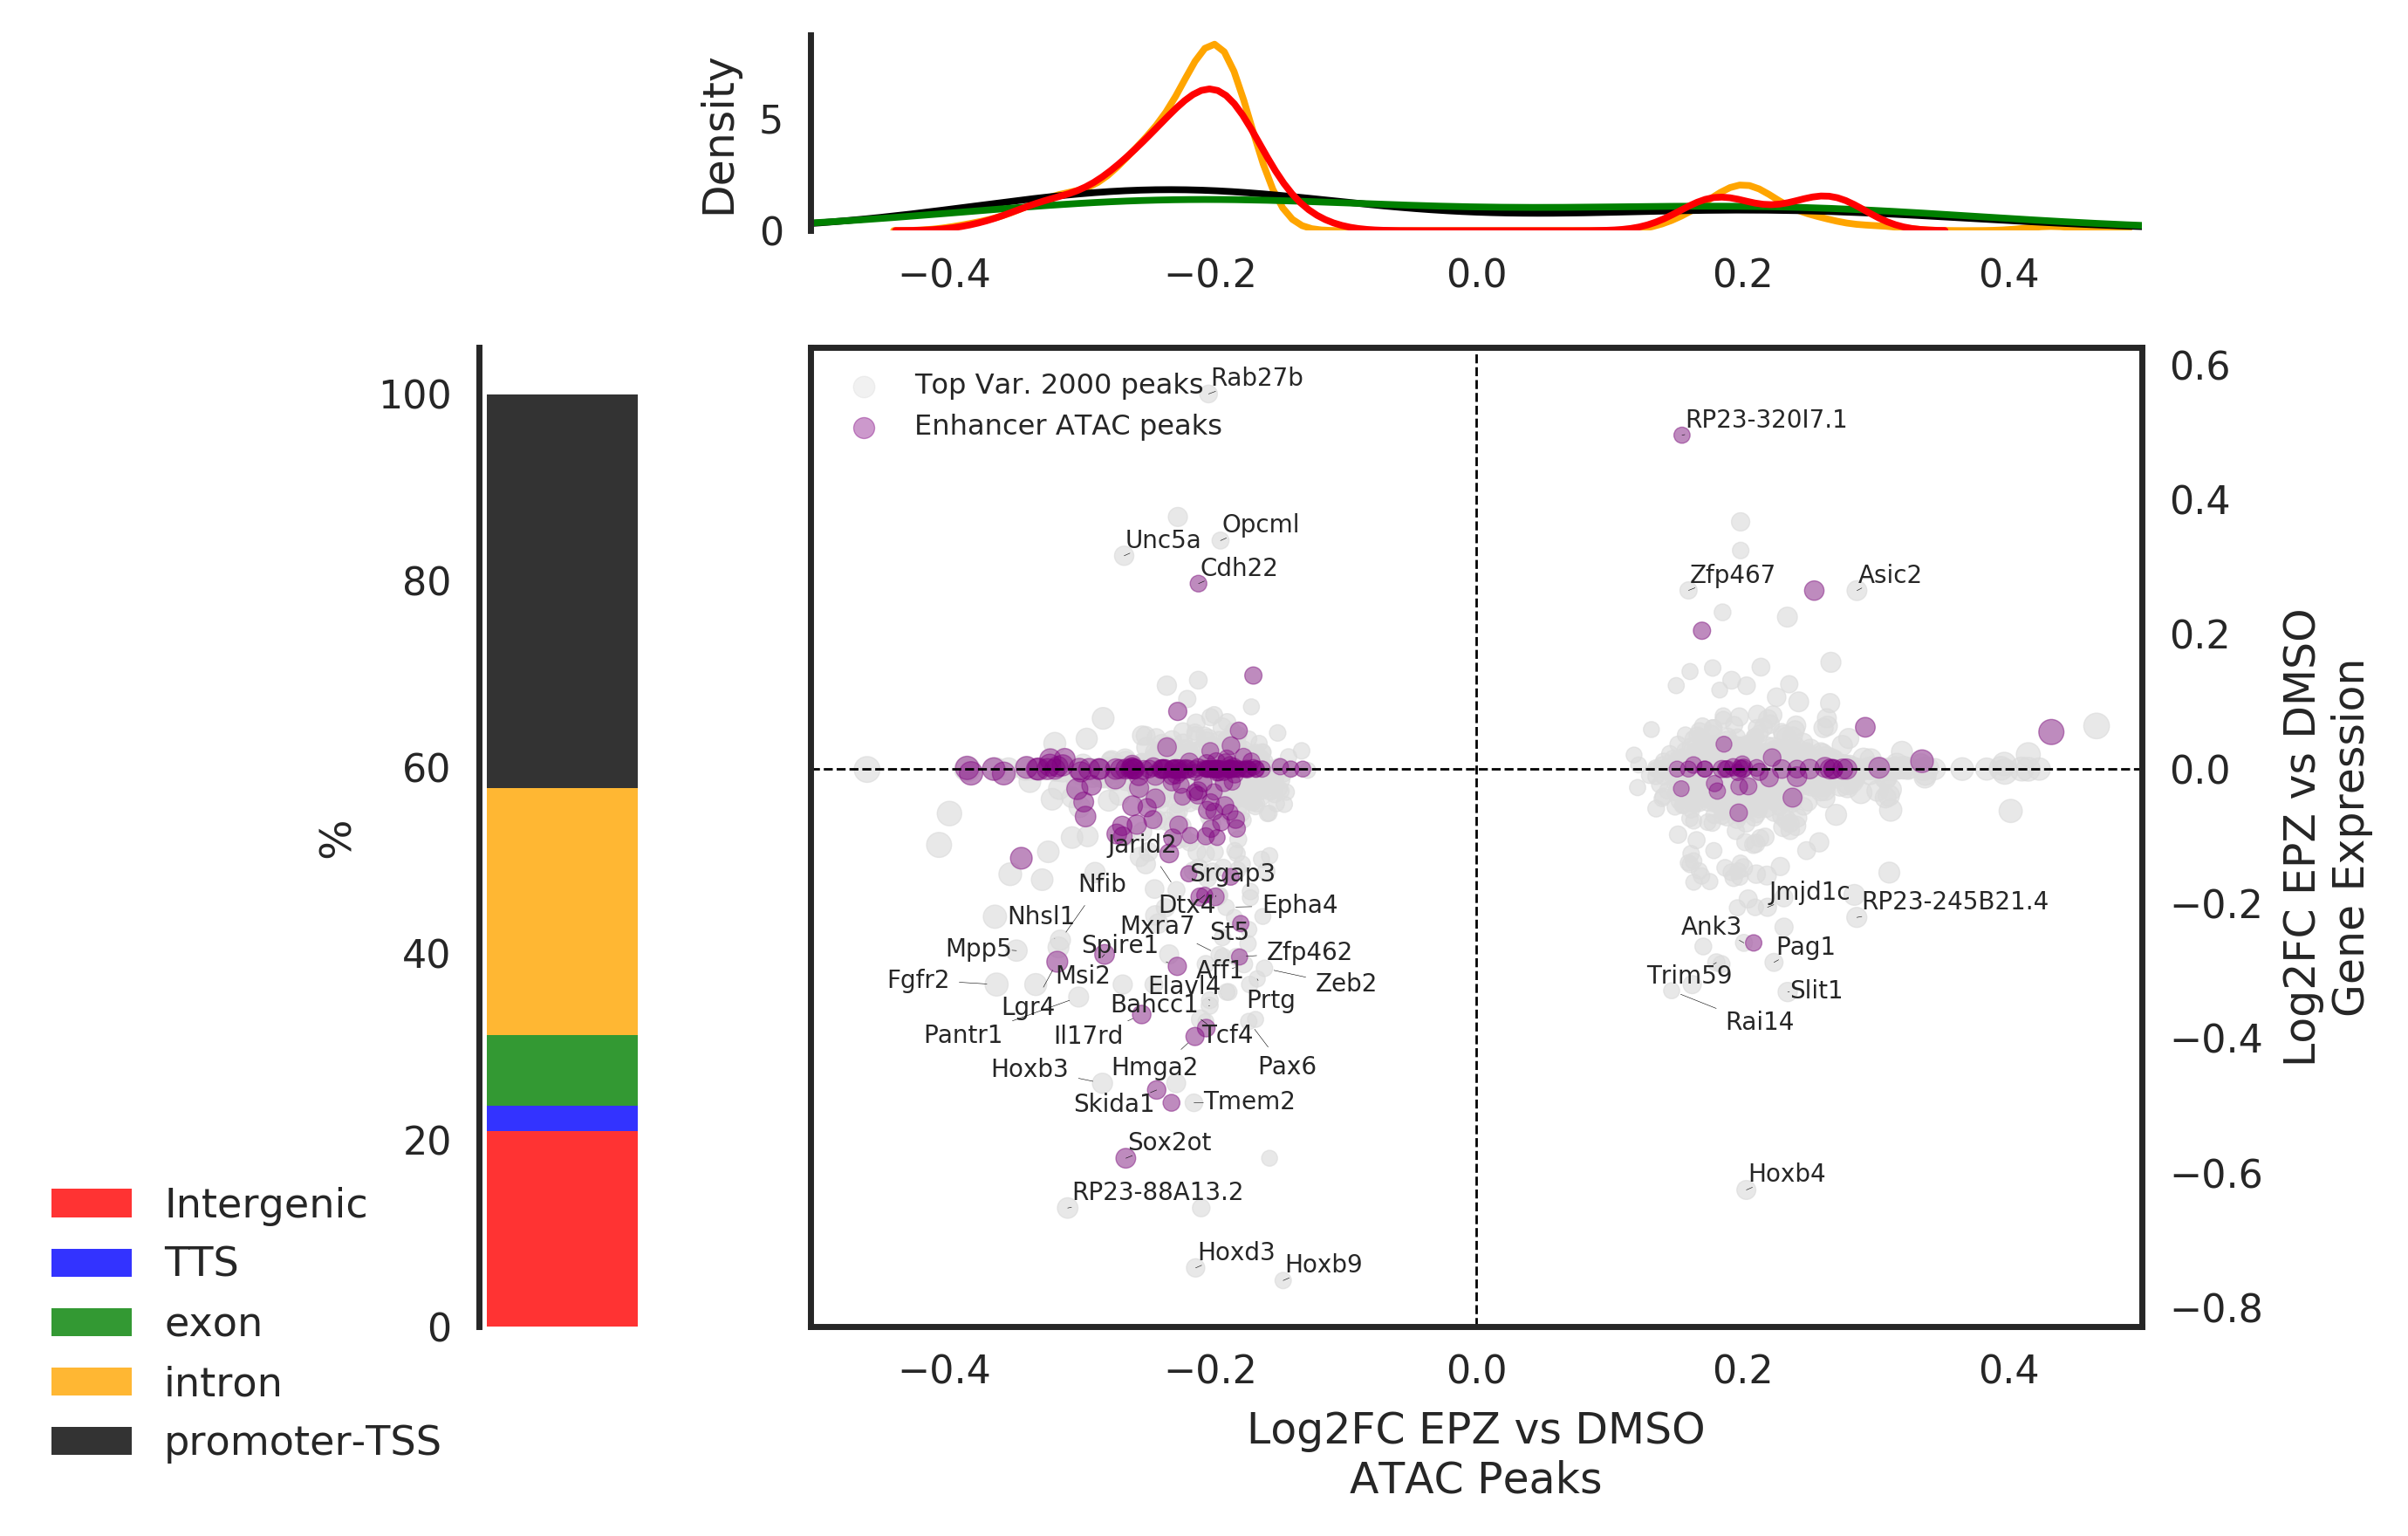

In [99]:
fig,ax = plt.subplots(2,2, dpi=400,figsize=(7,4.5), gridspec_kw = {'width_ratios':[1,8], 'height_ratios':[1,5]})

padj_thr = 0.05
load_thr = 0.001

ax[1][1].yaxis.tick_right()
ax[1][1].yaxis.set_label_position("right")
ax[1][1].scatter(final_table_6["LogRatio"].values,final_table_6["log2FoldChange"].values,s=np.fabs(final_table_6.Loadings_PC1*1000), color='gainsboro', label="Top Var. 2000 peaks", alpha=0.4)
#plt.scatter(final_table_5["LogRatio"].values[:100],final_table_5["log2FoldChange"].values[:100],s=1)
#plt.scatter(final_table_5["LogRatio"].values[100:],final_table_5["log2FoldChange"].values[100:],s=1)
#ax[1].scatter(final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values,final_table_5["log2FoldChange"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values,s=np.fabs(final_table_5.Loadings_PC1.loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)]*1000), facecolor='darkorange',edgecolor='r', alpha=0.4, label="Peaks proximal to Sig. Upregulated Genes")
#ax[1].scatter(final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values,final_table_5["log2FoldChange"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values,s=np.fabs(final_table_5.Loadings_PC1.loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)]*1000), facecolor='g',edgecolor='b', alpha=0.4, label="Peaks proximal to Sig. Downregulated Genes")
col_dix = {"Intergenic":"r", "intron":"orange", "exon":"g","TTS":"b", "promoter-TSS":'k'}
cols = [col_dix[i] for i in final_table_6.Annotation_type.loc[np.fabs(final_table_6.Loadings_PC1)>load_thr].values]
ax[1][1].scatter(final_table_6["LogRatio"].loc[np.fabs(final_table_6.Loadings_PC1)>load_thr].values,final_table_6["log2FoldChange"].loc[np.fabs(final_table_6.Loadings_PC1)>load_thr].values,s=np.fabs(final_table_6.Loadings_PC1.loc[np.fabs(final_table_6.Loadings_PC1)>load_thr]*1000), color = "gainsboro", alpha=0.4)
ax[1][1].scatter(final_table_6["LogRatio"].loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6[5]=="yes")].values,final_table_6["log2FoldChange"].loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr)& (final_table_6[5]=="yes")].values,s=np.fabs(final_table_6.Loadings_PC1.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr)& (final_table_6[5]=="yes")]*1000), color = "purple", alpha=0.4, label="Enhancer ATAC peaks")


#print(final_table_5[["name",'chr','start','end']].loc[(final_table_5.padj<0.1)&(final_table_5.log2FoldChange<0)])
#print(len(final_table_5["name"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)]))
ax[1][1].axvline(0,linestyle="--",linewidth=0.5, color='k')
ax[1][1].axhline(0,linestyle="--",linewidth=0.5,color='k')
ax[1][1].set_ylabel("Log2FC EPZ vs DMSO\nGene Expression")
ax[1][1].set_xlabel("Log2FC EPZ vs DMSO\nATAC Peaks")
#ax[1].set_title("Top 500 PC1 ATAC Loadings")
ax[1][1].legend(loc=2,fontsize="xx-small")

#idx = final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].index
#idx2 = final_table_5["LogRatio"].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].index


#texts = [plt.text(final_table_5["LogRatio"].loc[idx].values[i], final_table_5["log2FoldChange"].loc[idx].values[i], "{}".format(final_table_5[["name"]].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values[i][0],final_table_5[["Annotation_type"]].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange<0)].values[i][0]), ha='center', va='center',  fontsize=5) for i in range(len(idx))]
#texts2 = [plt.text(final_table_5["LogRatio"].loc[idx2].values[i], final_table_5["log2FoldChange"].loc[idx2].values[i], "{}".format(final_table_5[["name"]].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values[i][0],final_table_5[["Annotation_type"]].loc[(final_table_5.padj<padj_thr)&(final_table_5.log2FoldChange>0)].values[i][0]), ha='center', va='center',  fontsize=5) for i in range(len(idx2))]


#adjust_text(texts)
#adjust_text(texts2)

anntype = (final_table_5.groupby("Annotation_type").count()["DMSO1"] / final_table_5.shape[0] ) * 100

color=['r','b','g','orange','k']
for i in range(5):
    ax[1][0].bar([0], \
            anntype.values[i], \
            bottom = np.cumsum([0]+list(anntype.values[:-1]))[i], \
            color=color[i], label = anntype.index[i], alpha=0.8)

ax[1][0].legend(fontsize="small", loc='upper right', bbox_to_anchor=(0, 0.18))
ax[1][0].set_xticks([])
ax[1][0].set_ylabel("%")
# Hide the right and top spines
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['bottom'].set_visible(False)

ax[0][0].set_axis_off()

ax[0][1].spines['left'].set_visible(True)
ax[0][1].set_ylabel('Density')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['bottom'].set_visible(False)

idx = idx = final_table_6["symbol"].loc[(final_table_6.padj<padj_thr)&(final_table_6.log2FoldChange<0)].drop_duplicates().index
idx2 = final_table_6["symbol"].loc[(final_table_6.padj<padj_thr)&(final_table_6.log2FoldChange>0)].drop_duplicates().index


texts = [plt.text(final_table_6["LogRatio"].loc[idx].values[i], final_table_6["log2FoldChange"].loc[idx].values[i], "{}".format(final_table_6[["name"]].loc[idx].values[i][0]), ha='center', va='center',  fontsize=5) for i in range(len(idx))]
texts2 = [plt.text(final_table_6["LogRatio"].loc[idx2].values[i], final_table_6["log2FoldChange"].loc[idx2].values[i], "{}".format(final_table_6[["name"]].loc[idx2].values[i][0]), ha='center', va='center',  fontsize=5) for i in range(len(idx2))]


adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.1))
adjust_text(texts2,arrowprops=dict(arrowstyle="-", color='k', lw=0.1))




sns.distplot(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "intron") & (final_table_6[5] == "yes")].values, \
             color='orange', bins=30, hist=False, ax=ax[0][1])
print(len(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "intron") & (final_table_6[5] == "yes")].values))
sns.distplot(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "promoter-TSS") & (final_table_6[5] == "yes")].values, \
             color='k', bins=30, hist=False, ax=ax[0][1])
print(len(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "promoter-TSS") & (final_table_6[5] == "yes")].values))
sns.distplot(final_table_6.LogRatio.loc[(np.fabs(final_table_5.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "exon") & (final_table_6[5] == "yes")].values, \
             color='g', bins=30, hist=False, ax=ax[0][1])
print(len(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "exon") & (final_table_6[5] == "yes")].values))
# sns.distplot(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6[5] == "yes")].values, \
#             color='darkgray', bins=30, hist=False, ax=ax[0][1])
sns.distplot(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "Intergenic") & (final_table_6[5] == "yes")].values, \
color='r', bins=30, hist=False, ax=ax[0][1])
print(len(final_table_6.LogRatio.loc[(np.fabs(final_table_6.Loadings_PC1)>load_thr) & (final_table_6.Annotation_type == "Intergenic") & (final_table_6[5] == "yes")].values))
# sns.distplot(final_table_5.LogRatio.loc[(np.fabs(final_table_5.Loadings_PC1)>load_thr) & (final_table_5.Annotation_type == "TTS") & (final_table_6[5] == "yes")].values, \
# color='b', bins=30, hist=False, ax=ax[0][1])

#ax[1].legend(fontsize="xx-small",loc=2)
ax[1][1].set_xlim((-0.5,0.5))
#ax[1][1].set_
ax[0][1].set_xlim((-0.5,0.5))
plt.tight_layout()

plt.savefig("../FIGURES/Diff_ATACPeaks_Enhancers.png")

In [109]:
%%bash 

module load deeptools

computeMatrix reference-point -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_*_ATAC.filtered.PeakScaled.bw \
-o ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks.mat.gz --referencePoint center -b 500 -a 500 -bs 5 --outFileNameMatrix ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks.txt \
--missingDataAsZero -p 20 




In [110]:
%%bash

source activate deepStats

dsCompareCurves -i ../INTERMEDIATE_FILES/ATAC_on_DynamicPeaks.txt -o ../INTERMEDIATE_FILES/DEEPSTATS_atac_on_dynamic \
-c score --regionLabels 'ATAC Down;ATAC Up; ATAC Random' --scoreLabels 'DMSO1;DMSO2;EPZ1;EPZ2' \
--signalName ATAC-seq --firstRegionName 'PEAK CENTER'



2019-10-16 13:48:28 Extracting metadata from file:
    /data/manke/group/ferrari/PhD_project/reproducible_code_paper/code_paper/figure_4/INTERMEDIATE_FILES/ATAC_on_DynamicPeaks.txt ... Done!
2019-10-16 13:48:28 --comparison is set: comparing scores.
2019-10-16 13:48:29 Boostraps starting with 4 cores, for each group:
   Number of bootstraps to perform = 1000 
   Number of bins to analyze = 200 
2019-10-16 13:48:29 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used: ATAC Down 
   Number of regions to analyze: 953... Done!
2019-10-16 13:48:33 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used: ATAC Up 
   Number of regions to analyze: 1047... Done!
2019-10-16 13:48:38 Starting to boostrap values for the following group:
   Genomic score used: DMSO1 
   Region set used:  ATAC Random 
   Number of regions to analyze: 1000... Done!
2019-10-16 13:48:42 Starting to boostrap values for the fol

In [126]:
%%bash 

awk -v OFS="\t" '{printf "%s\t%d\t%d\n", $1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE_Ext.bed
awk -v OFS="\t" '{printf "%s\t%d\t%d\n", $1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv > ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE_Ext.bed
awk -v OFS="\t" '{printf "%s\t%d\t%d\n", $1,($2+(($3-$2)/2))-500,($2+(($3-$2)/2))+500}' ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed > ../INTERMEDIATE_FILES/Random_ATAC_peaks_Ext.bed



In [127]:
%%bash

source activate gimme

gimme motifs -n ../INTERMEDIATE_FILES/motifs_DownATACPeaks \
-g /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE_Ext.bed

/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [130]:
%%bash

source activate gimme

gimme motifs -n ../INTERMEDIATE_FILES/motifs_UpATACPeaks \
-g /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE_Ext.bed

/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ferrari/anaconda3/envs/gimme/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

# PLOT SOX2 SIGNAL ON UP- AND DOWN-ATAC

In [69]:
peak = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_ATAC_DMSO-EPZ.counts",sep="\t")
peak.columns = ["chr","start","end","DMSO1","DMSO2","EPZ1","EPZ2"]

peak = rel.preprocess_deeptools(peak)
1/rel.RLE(peak)[0]

DMSO1    0.637267
DMSO2    1.059848
EPZ1     1.164837
EPZ2     1.261095
dtype: float64

In [71]:
%%bash

bamCompare -b1 /home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/filtered_bam/NPC48hs_EPZ2.filtered.bam \
-b2 /home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/filtered_bam/NPC48hs_DMSO2.filtered.bam \
--scaleFactorsMethod None --scaleFactors 1.261095:1.059848 -p 20 -o ../INTERMEDIATE_FILES/NPC48h_ATAC_EPZ-DMSO_log2.scaled.bw

bamFilesList: ['/home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/filtered_bam/NPC48hs_EPZ2.filtered.bam', '/home/ferrari/ferrari/PhD_project/reference_datasets/Franz_Vogel_dataset/ATAC-Seq/output_ATAC-Seq_snakepipe/filtered_bam/NPC48hs_DMSO2.filtered.bam']
binLength: 50
numberOfSamples: 0
blackListFileName: None
defaultFragmentLength: read length
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000


In [72]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/SOX2_ChIP-Seq_NSC_GSE90559/output_snakepipes/deepTools_ChIP/bamCompare/Sox2_ChIP_Singles.filtered.subtract.Input_DNA_Singles.bw \
../INTERMEDIATE_FILES/NPC48h_ATAC_EPZ-DMSO_log2.scaled.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27ac_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me1_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_1.mat.gz --missingDataAsZero -p 20

In [62]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv ../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/POU3F2_SOX2_ChIP-Seq_NPC_GSE35496/output_snakePipes/deepTools_ChIP/bamCompare/Sox2_NPC_rep1.filtered.subtract.input_NPC.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/POU3F2_SOX2_ChIP-Seq_NPC_GSE35496/output_snakePipes/deepTools_ChIP/bamCompare/Pou3f2_NPC_rep1.filtered.subtract.input_NPC.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/TCF4_bHLH_ChIP-Seq_NSC_GSE70872/output_snakePipes/bamCoverage/TCF4_NSC-NS5-V5_ChIP-Seq.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep1_ATAC.filtered.PeakScaled.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27ac_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me1_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_Sox_Pou.mat.gz --missingDataAsZero -p 20

In [51]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_onSigDown_NPC.bed ../INTERMEDIATE_FILES/ATAC_onSigUP_NPC.bed ../INTERMEDIATE_FILES/ATAC_onBackground_NPC.bed \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/POU3F2_SOX2_ChIP-Seq_NPC_GSE35496/output_snakePipes/deepTools_ChIP/bamCompare/Sox2_NPC_rep1.filtered.subtract.input_NPC.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/POU3F2_SOX2_ChIP-Seq_NPC_GSE35496/output_snakePipes/deepTools_ChIP/bamCompare/Pou3f2_NPC_rep1.filtered.subtract.input_NPC.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/TCF4_bHLH_ChIP-Seq_NSC_GSE70872/output_snakePipes/bamCoverage/TCF4_NSC-NS5-V5_ChIP-Seq.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep1_ATAC.filtered.PeakScaled.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27ac_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me1_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_Sox_Pou.mat.gz --missingDataAsZero -p 20

In [7]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-POSITIVE.tsv \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/SOX2_ChIP-Seq_NSC_GSE90559/output_snakepipes/deepTools_ChIP/bamCompare/Sox2_ChIP_Singles.filtered.subtract.Input_DNA_Singles.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27ac_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me1_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_down.mat.gz --missingDataAsZero -p 20

In [8]:
%%bash

##### PLOT SOX2 SIGNAL ON UP AND DOWN ATAC PEAKS

computeMatrix reference-point --referencePoint center -R ../INTERMEDIATE_FILES/ATAC_topVar_PC1_LOADING-NEGATIVE.tsv \
-S /home/ferrari/ferrari/PhD_project/reference_datasets/SOX2_ChIP-Seq_NSC_GSE90559/output_snakepipes/deepTools_ChIP/bamCompare/Sox2_ChIP_Singles.filtered.subtract.Input_DNA_Singles.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K27ac_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me1_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/deepTools_ChIP/bamCompare/iNPC_DMSO_rep1_H3K4me3_merged.filtered.subtract.iNPC_DMSO_rep1_Input.bw \
-a 2000 -b 2000 -o ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_up.mat.gz --missingDataAsZero -p 20

In [18]:
%%bash

plotHeatmap -h

usage: plotHeatmap [--matrixFile MATRIXFILE] --outFileName OUTFILENAME
                   [--outFileSortedRegions FILE] [--outFileNameMatrix FILE]
                   [--interpolationMethod STR] [--dpi DPI] [--kmeans KMEANS]
                   [--hclust HCLUST] [--help] [--version]
                   [--sortRegions {descend,ascend,no,keep}]
                   [--sortUsing {mean,median,max,min,sum,region_length}]
                   [--sortUsingSamples SORTUSINGSAMPLES [SORTUSINGSAMPLES ...]]
                   [--averageTypeSummaryPlot {mean,median,min,max,std,sum}]
                   [--missingDataColor MISSINGDATACOLOR]
                   [--colorMap COLORMAP [COLORMAP ...]] [--alpha ALPHA]
                   [--colorList COLORLIST [COLORLIST ...]]
                   [--colorNumber COLORNUMBER] [--zMin ZMIN [ZMIN ...]]
                   [--zMax ZMAX [ZMAX ...]] [--heatmapHeight HEATMAPHEIGHT]
                   [--heatmapWidth HEATMAPWIDTH]
                   [--whatToShow {plot, heat

In [76]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_1.mat.gz -o ../FIGURES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_1.pdf \
--refPointLabel "peak center" --regionsLabel "ATAC DOWN" "ATAC UP" "ATAC RANDOM" --samplesLabel "SOX2" "ATAC" "H3K27ac" "H3K4me1" "H3K4me3" \
--heatmapHeight 23 --heatmapWidth 4.5 --colorMap  "Reds" "RdBu_r" "Greens" "Purples" "Blues" --yMax 30 1 12 12 12 --yMin -2 -1 -2 -2 -2 --zMax 15 1 10 10 10 --zMin -2 -1 -2 -2 -2


In [64]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_Sox_Pou.mat.gz -o ../FIGURES/SOX2_POU3F2_ON_DYNAMIC_ATAC_PEAKS_histMarks.pdf --colorMap "RdBu_r" \
--refPointLabel "peak center" --heatmapHeight 23 --heatmapWidth 4.5 --colorMap "RdBu_r" "PiYG" "Reds" "bone" "Greens" "Blues" "Greys"  \
--zMax 10 10 10 16 8 8 8  --regionsLabel "ATAC DOWN" "ATAC UP" "ATAC RANDOM" --samplesLabel "SOX2" "POU3F2" "TCF4" "ATAC" "H3K27ac" "H3K4me1" "H3K4me3" --yMax 30 30 30 30 15 15 15 \

In [11]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_down.mat.gz -o ../FIGURES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_down.png --colorMap "RdBu_r" \
--kmeans 2 --refPointLabel "peak center" --samplesLabel "SOX2" "H3K27ac" "H3K4me1" "H3K4me3" 
#--regionsLabel "ATAC_DOWN"

/home/ferrari/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88



In [12]:
%%bash

plotHeatmap -m ../INTERMEDIATE_FILES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_up.mat.gz -o ../FIGURES/SOX2_ON_DYNAMIC_ATAC_PEAKS_histMarks_up.png --colorMap "RdBu_r" \
--refPointLabel "peak center" --samplesLabel "SOX2" "H3K27ac" "H3K4me1" "H3K4me3" --kmeans 2
#--regionsLabel "ATAC UP"

/home/ferrari/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88



# PLOT FGFR2 LOCUS (PYGENOMETRACK)

In [157]:
%%bash

source activate pyGenomeTracks

make_tracks_file --trackFiles \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K79me2_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K79me2_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K27ac_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K27ac_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K4me1_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K4me1_merged.filtered.seq_depth_norm.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_ATAC.filtered.PeakScaled.bw \
/home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_ATAC.filtered.PeakScaled.bw \
/home/ferrari/ferrari/PhD_project/reference_datasets/SOX2_ChIP-Seq_NSC_GSE90559/output_snakepipes/bamCoverage/Sox2_ChIP_Singles.filtered.seq_depth_norm.bw \
../INTERMEDIATE_FILES/genes_ensembl91_sorted.bed -o ../INTERMEDIATE_FILES/tracks_.ini

Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K79me2_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K79me2_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K27ac_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K27ac_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_H3K4me1_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_H3K4me1_merged.filtered.seq_depth_norm.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_DMSO_rep2_ATAC.filtered.PeakScaled.bw
Adding bigwig file: /home/ferrari/ferrari/GEO_sumbission_inVitro/manke/NPC48h_EPZ_rep2_ATAC.filtered.Peak

In [171]:
%%bash

### plot Fgfr2 locus

source activate pyGenomeTracks 

pyGenomeTracks --tracks ../INTERMEDIATE_FILES/tracks_Fgfr2.ini --region 7:130245763-130269263 --outFileName ../FIGURES/Fgfr2.pdf



INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:8.083590984344482
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 25.0. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [NPC48h_DMSO_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 4. [NPC48h_EPZ_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 5. [NPC48h_DMSO_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 6. [NPC48h_EPZ_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 7. [NPC48h_DMSO_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 8. [NPC48h_EPZ_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 9. [NPC48h_DMSO_rep2_ATAC.filtered.PeakScaled]
IN

In [172]:
%%bash

### plot Msi2 locus

source activate pyGenomeTracks 

pyGenomeTracks --tracks ../INTERMEDIATE_FILES/tracks_Msi2.ini --region 11:88686567-88726761 --outFileName ../FIGURES/Msi2.pdf




INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:8.146137237548828
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 25.0. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [NPC48h_DMSO_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 4. [NPC48h_EPZ_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 5. [NPC48h_DMSO_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 6. [NPC48h_EPZ_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 7. [NPC48h_DMSO_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 8. [NPC48h_EPZ_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 9. [NPC48h_DMSO_rep2_ATAC.filtered.PeakScaled]
IN

In [170]:
%%bash

### plot Jarid2 locus

source activate pyGenomeTracks 

pyGenomeTracks --tracks ../INTERMEDIATE_FILES/tracks_Jarid2.ini --region 13:44728016-44765735 --outFileName ../FIGURES/Jarid2.pdf



INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:8.407744646072388
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 25.0. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [NPC48h_DMSO_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 4. [NPC48h_EPZ_rep2_H3K79me2_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 5. [NPC48h_DMSO_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 6. [NPC48h_EPZ_rep2_H3K27ac_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 7. [NPC48h_DMSO_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 8. [NPC48h_EPZ_rep2_H3K4me1_merged.filtered.seq_depth_norm]
INFO:pygenometracks.tracksClass:plotting 9. [NPC48h_DMSO_rep2_ATAC.filtered.PeakScaled]
IN

In [75]:
peak = pd.read_csv("../INTERMEDIATE_FILES/NPC48h_ATAC_DMSO-EPZ.counts",sep="\t")
peak.columns = ["chr","start","end","DMSO1","DMSO2","EPZ1","EPZ2"]
peak = peak.loc[peak.chr != "MT"]

peak.sample(1000)[["chr","start","end"]].to_csv("../INTERMEDIATE_FILES/Random_ATAC_peaks_1000.bed",sep="\t",header=None,index=None)

peak["ID"] = ['_'.join([str(peak.chr.loc[i]), str(peak.start.loc[i]),str(peak.end.loc[i])]) for i in peak.index]
peak = peak[list(peak)[3:]]
peak.drop_duplicates("ID",inplace=True)
print(peak.shape)
peak.head()


(32232, 5)


,DMSO1,DMSO2,EPZ1,EPZ2,ID
0,6.0,14.0,5.0,23.0,18_89620972_89621286
1,285.0,131.0,142.0,118.0,7_43562057_43562893
2,328.0,186.0,206.0,190.0,7_43579417_43580316
3,15.0,9.0,8.0,22.0,17_90018305_90018554
4,36.0,41.0,23.0,32.0,17_90086889_90087150


In [76]:
peak.index = peak.ID
peak.drop("ID", axis=1, inplace=True)
peak.head()
peak = rel.RLE(peak)[1]
peak

,DMSO1,DMSO2,EPZ1,EPZ2
ID,,,,
18_89620972_89621286,3.823601,14.837871,5.824187,29.005196
7_43562057_43562893,181.621066,138.840076,165.406912,148.809268
7_43579417_43580316,209.023542,197.131711,239.956507,239.608143
17_90018305_90018554,9.559003,9.538631,9.318699,27.744101
17_90086889_90087150,22.941608,43.453764,26.791260,40.355056
...,...,...,...,...
4_134631859_134632283,63.726690,55.112091,34.945122,51.704915
4_134675855_134676305,77.746561,91.146920,86.197968,71.882443
12_52769549_52770225,56.716754,72.069658,93.186993,85.754493


In [77]:
sig_peak = pd.read_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv",sep="\t")
sig_peak = sig_peak.peak_id
sig_peak

0        12_12723075_12724107
1        15_74958663_74959169
2        11_20830556_20831732
3         4_65699964_65700588
4         3_38912896_38914192
                ...          
1995      5_85239477_85240520
1996    3_144719414_144719692
1997    4_136776379_136776958
1998      5_91139473_91140033
1999      7_27507747_27508789
Name: peak_id, Length: 2000, dtype: object

In [78]:
peak_fin = peak.loc[sig_peak]
peak_fin

,DMSO1,DMSO2,EPZ1,EPZ2
ID,,,,
12_12723075_12724107,332.016053,337.031635,216.659758,200.514183
15_74958663_74959169,16.568939,16.957567,74.549594,66.838061
11_20830556_20831732,114.070775,77.368897,147.934351,185.381037
4_65699964_65700588,45.883217,31.795437,104.835367,88.276684
3_38912896_38914192,295.054573,358.228593,218.989433,209.341851
...,...,...,...,...
5_85239477_85240520,224.317948,219.388517,205.011384,163.942413
3_144719414_144719692,37.598747,51.932547,18.637399,30.266292
4_136776379_136776958,104.511771,139.899924,81.538619,109.715307


In [79]:
annot = pd.read_csv("../INTERMEDIATE_FILES/Final_Table_topPC1ATACPeaks.tsv", sep="\t")
JARID2 = annot.loc[annot.symbol=="Jarid2"].peak_id.values[0]
MSI2 = annot.loc[annot.symbol=="Msi2"].peak_id.values
JARID2
MSI2

array(['11_88582556_88583742', '11_88702276_88703636'], dtype=object)

In [80]:
means

ID
12_12723075_12724107    -125.936873
15_74958663_74959169      53.930575
11_20830556_20831732      70.937858
4_65699964_65700588       57.716699
3_38912896_38914192     -112.475941
                            ...    
5_85239477_85240520      -37.376333
3_144719414_144719692    -20.313802
4_136776379_136776958    -26.578884
5_91139473_91140033       20.705364
7_27507747_27508789      -44.272288
Length: 2000, dtype: float64

/home/ferrari/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ferrari/.local/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


-1.5595814946459703


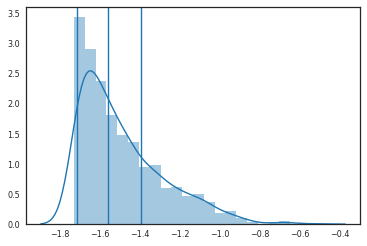

In [81]:
means = peak_fin[["EPZ1","EPZ2"]].mean(axis=1) - peak_fin[["DMSO1","DMSO2"]].mean(axis=1)
means_1 = means.loc[means<0]
std = peak_fin[["DMSO1","DMSO2","EPZ1","EPZ2"]].std(axis=1)
std_1 = std.loc[means<0]
cohen = means_1 / std_1

sns.distplot(cohen)
plt.axvline(cohen.loc[JARID2])
plt.axvline(cohen.loc[MSI2[0]])
plt.axvline(cohen.loc[MSI2[1]])
print(cohen.loc[JARID2])



In [82]:
targets = {"chr":[13,13,11,7,1,4,12,11,11,3,16],
           "start":[44751697,44755288,88701908,130264397,42686676,55004981,78777915,120235950,79660385,68572145,62846860],
           "end":[44752196,44755933,88703184,130265227,42687048,55005301,78778316,120236473,79660783,68572639,62847346],
           "Gene":["Jarid2","Jarid2","Msi2","Fgfr2","Pantr1","Zfp462","Mpp5","Bahcc1","Rab11fip4","Schip1","Arl13b"]}
pd.DataFrame(targets).to_csv("../INTERMEDIATE_FILES/TARGET_REGIONS_FOR_CHIP-QPCR.bed",sep="\t",index=False,header=False)
#chr13:44751697-44752196
#chr13:44755288-44755933
#chr11:88701908-88703184
#chr7:130264397-130265227

In [83]:
%%bash

bedtools getfasta -fi /data/repository/organisms/GRCm38_ensembl/genome_fasta/genome.fa \
-fo ../INTERMEDIATE_FILES/TARGET_REGIONS_FOR_CHIP-QPCR.fa -name+ -bed ../INTERMEDIATE_FILES/TARGET_REGIONS_FOR_CHIP-QPCR.bed

In [84]:
!cat ../INTERMEDIATE_FILES/TARGET_REGIONS_FOR_CHIP-QPCR.fa

>Jarid2::13:44751697-44752196
TCATCTGGAAAACAGCCGCTACATCCCTCCCACTAAAATTAAAATTGCTTATTAGAGCTAATTTTAGAATTGAGTTAGAACTGCCCTATAATGTAATGCAGACTATTTCCCAATAATGCCTAGGTTAACAATGATAGTCTTGCTGTATTGTGCAAAAAAGGCTTCTGTTCAGACCCAGCTGGGTTTCAGGCTTAATTCATTGCTCTATGGTGGGATCACCACAGCTGCTGTGGGGCCTTTACAAATGCAAAAAAGCTGTCAGTGTTTGTTTCATCAGCTGCATAAGTGATGAGGCCAAGTTGAGGAATCCATTCCAGTGCGCAGTGTGCAGGCTGTAGCCATTATTGTTTACAGAATTAGTGTGTTGGAGCTTTAAAATAGTTGGCACATCATCTGCCCTTTAAGAGGCGTAGACTAAGGAACCTGGGACAGTTGGTTGTCCTTGTAGTGCTTGTGGGTCCCGGTCCTGGTCTTTTAACAGGGCTCTTGTCTTAACCCC
>Jarid2::13:44755288-44755933
ACTGCTAATAGAAAATAAAAAGTTCATTTGCCACAGTGATTGTCATTTCCTTCTTAGGAGCGCAGCTTAACTCCAGGACTTCATTTAGTCGGAGGAAAATGGTTGCTACCTCCCTGTTAAGCTGTTTTCCATTCTCCAGTTGTAGCAGAAAGACTGTTGGGGAGGCCTGGGGAGCTGGGGGTCACATAAAGGAAGACTAAGAAGGGCTGCTGCAGAATGTGTTCTTCTGTCTGGAAGCCTGTGTGGAGAGGGTGGTAGCTTTAGAAAAGGGGGTGAAGTAGGAGGGGGCAGCAGTCGCTGAAGCATGACAAGCTTCCAAAGGCCCCGGGACTTGAACACAAAAAAGAGAGCTTTTTGCAGCTCTTTCACTGCACTTGTCTCCCTCAGCTCCATCCATTCTCCCCTGCTGTTTTGTAAATCTCCCAGTTGGAAATTTCTAA